In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load and Prepare ETH-USD Data

In [3]:
data = pd.read_csv('eth-usd-max.csv')
data.head()

,snapped_at,price,market_cap,total_volume
0,2015-08-07 00:00:00 UTC,2.831620,0.000000e+00,9.062200e+04
1,2015-08-08 00:00:00 UTC,1.330750,8.033948e+07,3.680700e+05
2,2015-08-10 00:00:00 UTC,0.687586,4.155631e+07,4.004641e+05
3,2015-08-11 00:00:00 UTC,1.067379,6.453901e+07,1.518998e+06
4,2015-08-12 00:00:00 UTC,1.256613,7.601326e+07,2.073893e+06


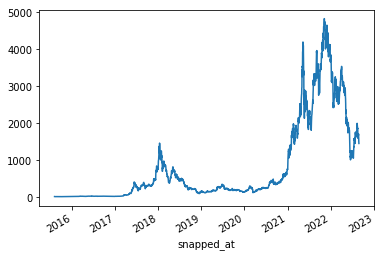

In [4]:
data['snapped_at'] = pd.to_datetime(data['snapped_at'])
data = data.set_index(data.snapped_at)
data.loc[(data.index >= '2015-01-01')].price.plot()

In [5]:
# Remove early life cycle data from pre-2017
data = data.loc[(data.index >= '2017-01-01')]
data['logret'] = np.log(data.price)-np.log(data.price).shift(1)
data['ret'] = data.price/data.price.shift(1) -1
data.to_pickle('ethusd_2017.pkl')

mean return =  0.004027863001677458
std return =  0.05499907069966014


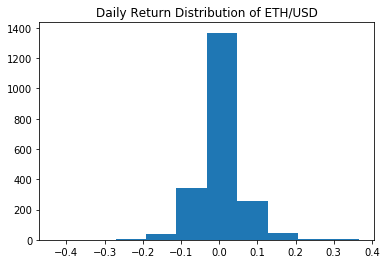

In [11]:
plt.hist(data.ret[1:])
plt.title('Daily Return Distribution of ETH/USD')
print('mean return = ',data.ret[1:].mean())
print('std return = ',data.ret[1:].std())

# Create bootstrap samples
Bootstrapped samples of 1 year length are created to get a set of alternate synthetic returns series of the ETHUSD pair. These returns series can be viewed as alternate histories for the crypto pair. The returns series retain the statistical properies of the original emperical returns series. The cost of rebalancing due to impermanent loss (IL) will be estimated from these series and allows for the generation of a distribution of IL for particular rebalancing strategies.

In [12]:
import random
zeroarray = np.zeros((365,10000)) # 10k samples of 365days/1-year
bootstraprets = pd.DataFrame(zeroarray)
for i in bootstraprets.columns:
    bootstraprets[i] = np.random.choice(data.ret.tolist(), 365)
bootstraprets = bootstraprets.replace(to_replace=np.nan, value=0, inplace=False, limit=None, regex=False, method='pad')
bootstraprets.to_pickle('bootstraprets_ethusd_365days.pkl')

# Synth Price Series
The following computes the distribution of the compound annual (daily) growth rate (CAGR) of the bootstrapped series and compares it to the actual cagr of the real historic series.

median cagr =  1.002447745401
mean cagr =  1.0024724462368586
historic return series cagr =  1.0022109375517856


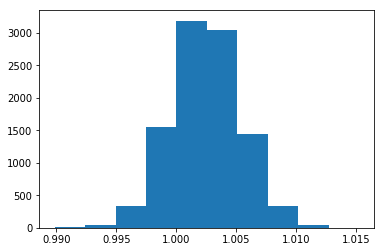

In [13]:
retseries = bootstraprets +1
priceseries = retseries.cumprod()
endingwealth = priceseries.iloc[364]
cagr = endingwealth**(1/365)
plt.hist(cagr)
realretseries = data.ret +1
realpriceseries = realretseries.cumprod()
realendingwealth = realpriceseries.iloc[364]
realcagr = realendingwealth**(1/len(data))
print('median cagr = ',cagr.median())
print('mean cagr = ',cagr.mean())
print('historic return series cagr = ',realcagr)

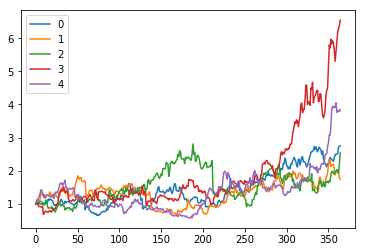

In [14]:
priceseries.iloc[:,0:5].plot();

# Stationary Synthetic Price Series
One issue with using the historical return series to test strategies and costs is that it assumes the future price action will be samples from the same distrubtion as the historic. As can be seen above the histoic returns of ETH is very good and it is unlikely to have the same performance. If it was assumed to have the same performance then just going long ETH/usd would be a a better strategy than trying to generate return from providing liquidity (LP) to a UniV2 pool.

My proposed approach is to assume price directional uncertainty. The future direction of price cannot be determined and as such the expected return and cagr is assumed to be 0. The bootstrapped samples are modified such that this become true. To do this the cagr of the original historic series is subtracted from each of the bootstrapped samples returns.

median cagr =  1.0002338017566266
mean cagr =  1.0002580864894888


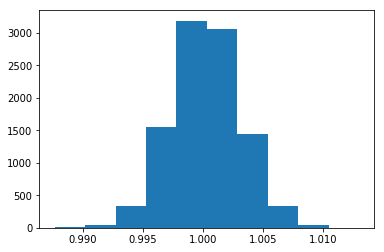

In [16]:
stationarybootstraprets = bootstraprets - realcagr +1
stationaryretseries = stationarybootstraprets +1
stationarypriceseries = stationaryretseries.cumprod()
stationaryendingwealth = stationarypriceseries.iloc[364]
stationarycagr = stationaryendingwealth**(1/365)
plt.hist(stationarycagr)
print('median cagr = ',stationarycagr.median())
print('mean cagr = ',stationarycagr.mean())
stationarybootstraprets.to_pickle('stationarybootstraprets_ethusd_365days.pkl')